In [1]:
from pathlib import Path
import os
import sys
path_dcf = str(Path(os.path.abspath('.')).resolve().parent)
sys.path.append(path_dcf)
from config import *
from algorithms.oneshot_dcf import DCF
from utils import *
from algorithms.utils_dilated_tubules import *
import pandas as pd
import tifffile
import matplotlib.pyplot as plt
import cv2
from torch_contour import CleanContours
height = 512

/local/scratch/tmp/ipykernel_3784186/1804606111.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Choose support image and corresponding contour

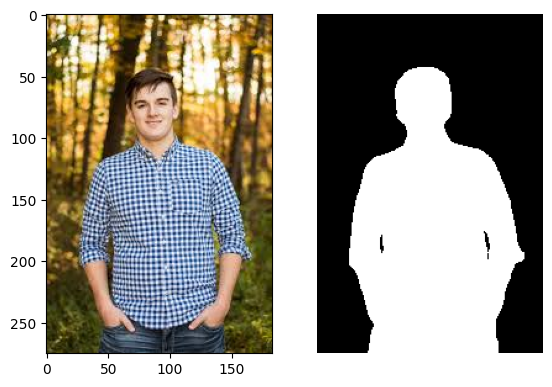

In [2]:
filename_support = "human1.jpg"
img = plt.imread(os.path.join(path_dcf,"images_test", filename_support)).astype(np.uint8)
gt =plt.imread(os.path.join(path_dcf,"images_test", "gt",filename_support.split('.')[-2]+".png")).astype(np.uint8)
f, axarr = plt.subplots(1,2)
plt.axis('off')
axarr[0].imshow(img)
axarr[1].imshow(gt, cmap='gray')
plt.show()

### Instanciate DCF one-shot

In [9]:
dcf = DCF(
    n_epochs=100,
    nb_augment=5,
    learning_rate=100,
    clip=1e-4,
    sigma=1,
    lambda_area=1.,
    exponential_decay=0.999,
    thresh=1e-2,
)

### Fit the one shot DCF on the support image and contour

In [10]:
img_support = cv2.resize(img, (height,height), interpolation = cv2.INTER_AREA).astype(np.uint8)
gt_support = cv2.resize(gt, (height,height), interpolation = cv2.INTER_AREA).astype(np.uint8)
contours = np.squeeze(cv2.findContours(gt,1,3)[0][-1])/height
c = CleanContours()
contour_support = c.interpolate(contours, 100).clip(0, 1)
contour_support = torch.tensor(contour_support)[None, None]
tensor_support = torch.tensor(np.moveaxis(img_support,-1,0)[None])/255

In [11]:
dcf.fit(tensor_support, contour_support)

fitting dcf one shot...


100%|██████████| 5/5 [00:00<00:00,  5.43it/s]


### Initialize contour and predict on the query

In [12]:
filename_query = "human2.jpg"
img_query = plt.imread(os.path.join(path_dcf,"images_test", filename_support)).astype(np.uint8)
img_query = cv2.resize(img_query, (height,height), interpolation = cv2.INTER_AREA).astype(np.uint8)
tensor_query = torch.tensor(np.moveaxis(img_query,-1,0)[None])/255

In [13]:
contour_init, mask = define_contour_init(
    height, center=[250, 250], axes=[250, 250], angle=0
)
x = contour_init / height

# ### Change the initial contour to set up a number of nobes
nb_nodes = 100
c = CleanContours()
contour_init = c.interpolate(x, nb_nodes).clip(0, 1)
# ### predict
contour_init = torch.tensor(contour_init)[None, None]

Contour is evolving please wait a few moments...


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


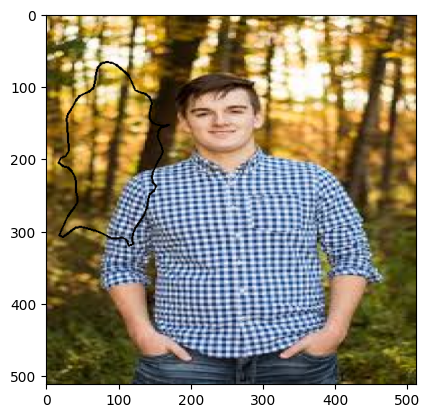

In [14]:
contours, score, tots, energies = dcf.predict(tensor_query,
                                               contour_init)


contour_to_display = (contours[0]*height).astype(int)
new_img = cv2.drawContours((((img_query/np.max(img_query))*255).astype(np.uint8)).copy(),
                        [contour_to_display],
                        0,
                        color = 1,
                        thickness=2)
plt.imshow(new_img)
plt.show()